<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/Data%20Augmentation/GradCamAndCutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, let us explore how to use
## [Grad-Cam](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/) and [CutOut](https://github.com/yu4u/cutout-random-erasing)



### Importing libraries 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.utils import np_utils

### Loading CIFAR10 dataset 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Visualize some sample Images from the dataset**

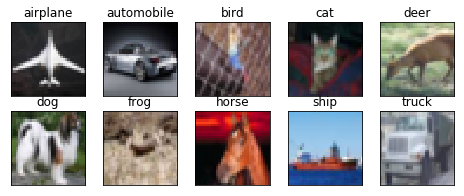

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Defining functions to plot model history, find accuracy**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def accuracy_iterator(test_iterator, model):
  _, accuracy = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
  return (accuracy * 100)

### Define Model and standardize the inputs

**Dividing pixel values by 255, standardize the inputs, also performed one hot encoding**

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), use_bias=False)) #30
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #28 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(64, (1, 1), activation='relu', use_bias=False)) #28
model.add(MaxPooling2D(pool_size=(2, 2)))#14

model.add(Convolution2D(128, (3, 3), padding='same', use_bias=False)) #12
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(64, (1, 1), activation='relu', use_bias=False)) #10
model.add(MaxPooling2D(pool_size=(2, 2)))#5

model.add(Convolution2D(128, (3, 3), padding='same', use_bias=False)) #3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #1
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(10, 8, 8, use_bias=False))
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), use_bias=False)`


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 128)       3456      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 256)       294912    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 256)      

In [0]:
# checkpoint
filepath="/content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=1, patience=5, min_lr=0.5e-9,verbose = 1)

In [0]:
callbacks_list = [earlystop, checkpoint, lr_reducer]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
391/391 [==============================] - 92s 236ms/step - loss: 2.1214 - acc: 0.3811 - val_loss: 1.7461 - val_acc: 0.4478

Epoch 00001: val_acc improved from -inf to 0.44780, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-01-0.45.hdf5
Epoch 2/100
391/391 [==============================] - 86s 220ms/step - loss: 1.5350 - acc: 0.5329 - val_loss: 1.4195 - val_acc: 0.4927

Epoch 00002: val_acc improved from 0.44780 to 0.49270, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-02-0.49.hdf5
Epoch 3/100
391/391 [==============================] - 86s 219ms/step - loss: 1.1144 - acc: 0.6221 - val_loss: 1.0521 - val_acc: 0.6211

Epoch 00003: val_acc improved from 0.49270 to 0.62110, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-03-0.62.hdf5
Epoch 4/100
391/391 [=====================

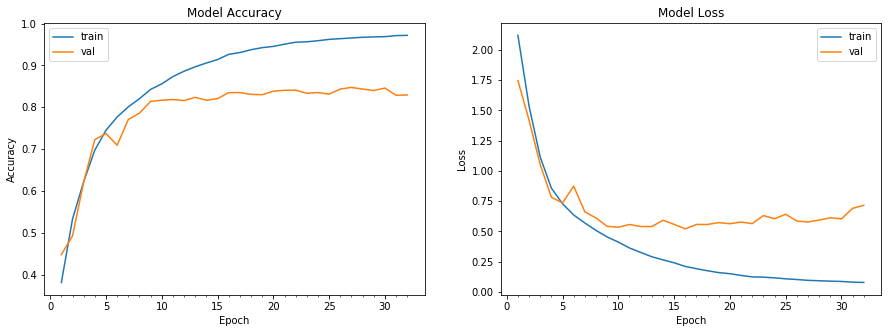

Accuracy on test data is: 82.94


In [0]:

from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=128)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=128, shuffle=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))

# With CutOuts

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
filepath="/content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')

lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=1, patience=5, min_lr=0.5e-9,verbose = 1)
# define early stopping callback
callbacks_list = [earlystop, checkpoint, lr_reducer]

Epoch 1/100
391/391 [==============================] - 86s 220ms/step - loss: 0.2825 - acc: 0.9040 - val_loss: 0.5062 - val_acc: 0.8438

Epoch 00001: val_acc improved from -inf to 0.84380, saving model to /content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-01-0.84.hdf5
Epoch 2/100
391/391 [==============================] - 86s 220ms/step - loss: 0.2339 - acc: 0.9200 - val_loss: 0.5671 - val_acc: 0.8394

Epoch 00002: val_acc did not improve from 0.84380
Epoch 3/100
391/391 [==============================] - 86s 220ms/step - loss: 0.2122 - acc: 0.9279 - val_loss: 0.5317 - val_acc: 0.8484

Epoch 00003: val_acc improved from 0.84380 to 0.84840, saving model to /content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-03-0.85.hdf5
Epoch 4/100
391/391 [==============================] - 86s 219ms/step - loss: 0.2027 - acc: 0.9293 - val_loss: 0.5805 - val_acc: 0.8453

Epoch 00004: val_acc did not improve from 0.84840
Epoch 5/100
391/391 [========================

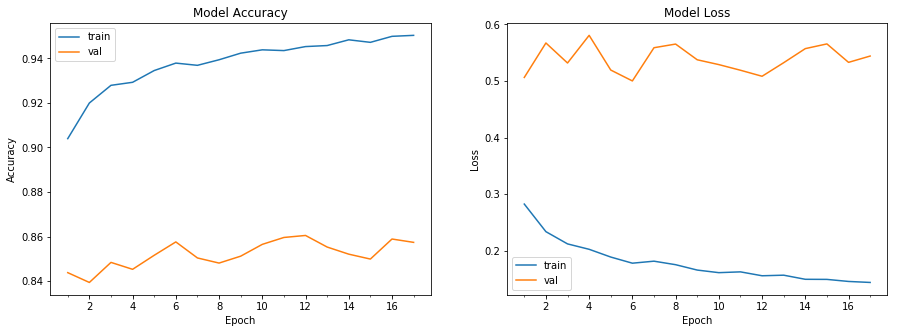

Accuracy on test data is: 85.74


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=128)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=128, shuffle=False)


# train the model
start = time.time()
# Train the model
cutout_model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(cutout_model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))

**With cutout the validation accuracy increased from 82.94 % to 85.74 %**

# GradCAM Analysis

In [0]:
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow, show
import keras.backend as K
from keras.models import load_model
import numpy as np
import cv2
import sys


In [5]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


In [8]:
#Load both the models, without Cutout and with Cutout

model = load_model("/content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-27-0.85.hdf5")
model1 = load_model("/content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-12-0.86.hdf5")












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
#Function to display images and heatmap images from two different models
def displayActivationMapImagesForIds(testX, imagesList):  
    for index in range(len(imagesList)):    
        img = testX[imagesList[index]]
        withoutCutoutImg = getGradCamImage(img, model, "conv2d_17")
        withCutoutImg = getGradCamImage(img, model1, "conv2d_17")
        concatimg = np.concatenate((img, withoutCutoutImg, withCutoutImg), axis=1)
        cv2.waitKey(1)
        print("Image Id: ",imagesList[index])
        cv2_imshow(concatimg)
        show()
        cv2.waitKey(2)

In [0]:
#Function to get GradCam Image
def getGradCamImage(img, model, layer):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(256):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype=cv2.CV_32F)
  return superimposed_img

[5991 6124 3665 5317  821 9900 2577  231 6892 4012]
Image Id:  5991


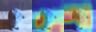

Image Id:  6124


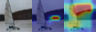

Image Id:  3665


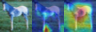

Image Id:  5317


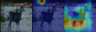

Image Id:  821


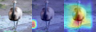

Image Id:  9900


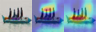

Image Id:  2577


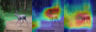

Image Id:  231


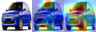

Image Id:  6892


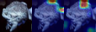

Image Id:  4012


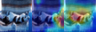

In [13]:
randomImages = np.random.randint(0, test_features.shape[0], size=(10))
print(randomImages)
layer = "conv2d_17"
displayActivationMapImagesForIds(test_features, randomImages)

## Observation:

### Without Cutouts, in many images model was looking at insignificant areas for prediction, however with cutouts, for most of the images heatmap is observed on relevant regions, improving model's accuracy  